<a href="https://colab.research.google.com/github/bkvkrll/Machine-Learning-in-Business/blob/main/lesson4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [137]:
%matplotlib inline

import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from sklearn.tree import DecisionTreeRegressor

скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention

In [138]:
df = pd.read_csv('data.csv')
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [139]:
df['client_id'] = np.random.randint(1, 50000, df.shape[0])

In [140]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion,client_id
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0,6397
1,6,329.08,1,1,Rural,1,Web,No Offer,0,2751
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0,41334
3,9,675.83,1,0,Rural,1,Web,Discount,0,7391
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0,32198


там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [141]:
df.rename(columns = {'conversion' : 'target', 'offer' : 'treatment_flg'}, inplace = True)
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment_flg,target,client_id
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0,6397
1,6,329.08,1,1,Rural,1,Web,No Offer,0,2751
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0,41334
3,9,675.83,1,0,Rural,1,Web,Discount,0,7391
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0,32198


In [142]:
df["treatment_flg"]=np.where(df["treatment_flg"] == "No Offer", 1, 0)
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment_flg,target,client_id
0,10,142.44,1,0,Surburban,0,Phone,0,0,6397
1,6,329.08,1,1,Rural,1,Web,1,0,2751
2,7,180.65,0,1,Surburban,1,Web,0,0,41334
3,9,675.83,1,0,Rural,1,Web,0,0,7391
4,2,45.34,1,0,Urban,0,Web,0,0,32198


In [143]:
df_clients=df
df_train=df.iloc[:,7:10]
df_test=df.iloc[:,9:10]
df_features = df_clients.copy()


In [144]:
indices_train = df_train.index
indices_test = df_test.index
indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=123)

In [145]:
df_train.groupby("treatment_flg")['target'].describe()

,count,mean,std,min,25%,50%,75%,max
treatment_flg,,,,,,,,
0,42694.0,0.167049,0.373024,0.0,0.0,0.0,0.0,1.0
1,21306.0,0.106167,0.308059,0.0,0.0,0.0,0.0,1.0


In [146]:
X_train = df_features.loc[indices_learn, :]
y_train = df_train.loc[indices_learn, 'target']
treat_train = df_train.loc[indices_learn, 'treatment_flg']

X_val = df_features.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']
treat_val =  df_train.loc[indices_valid, 'treatment_flg']

X_train_full = df_features.loc[indices_train, :]
y_train_full = df_train.loc[:, 'target']
treat_train_full = df_train.loc[:, 'treatment_flg']

X_test = df_features.loc[indices_test, :]

cat_features = ['zip_code','channel']

models_results_1 = {
    'approach': [],
    'uplift@10%': []
}

In [147]:
pip install scikit-uplift xgboost==1.0.2 category_encoders==2.1.0 -U

In [148]:
pip install catboost


In [149]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from catboost import CatBoostClassifier
from sklearn.linear_model import LinearRegression

uplift@10%: 0.0000


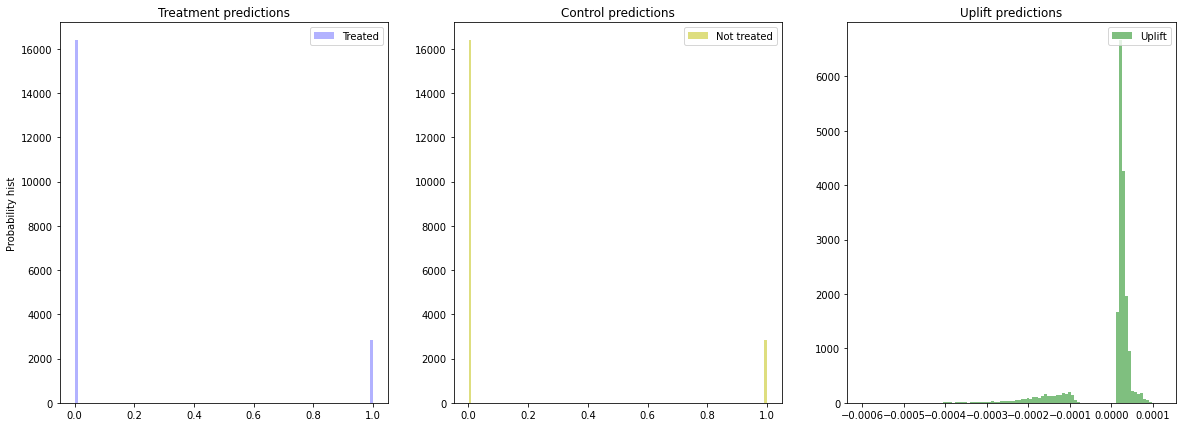

In [150]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})
uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)
print(f'uplift@10%: {sm_score:.4f}')

models_results_1['approach'].append('SoloModel')
models_results_1['uplift@10%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [151]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)

models_results_1['approach'].append('ClassTransformation')
models_results_1['uplift@10%'].append(ct_score)

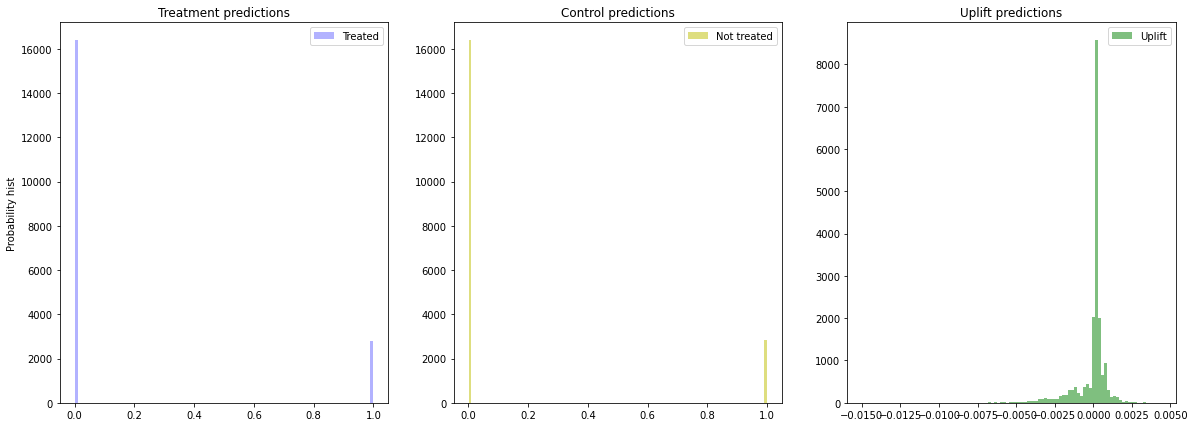

In [152]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)

models_results_1['approach'].append('TwoModels')
models_results_1['uplift@10%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [153]:
models_results_2 = {
    'approach': [],
    'uplift@20%': []
}

uplift@20%: 0.0000


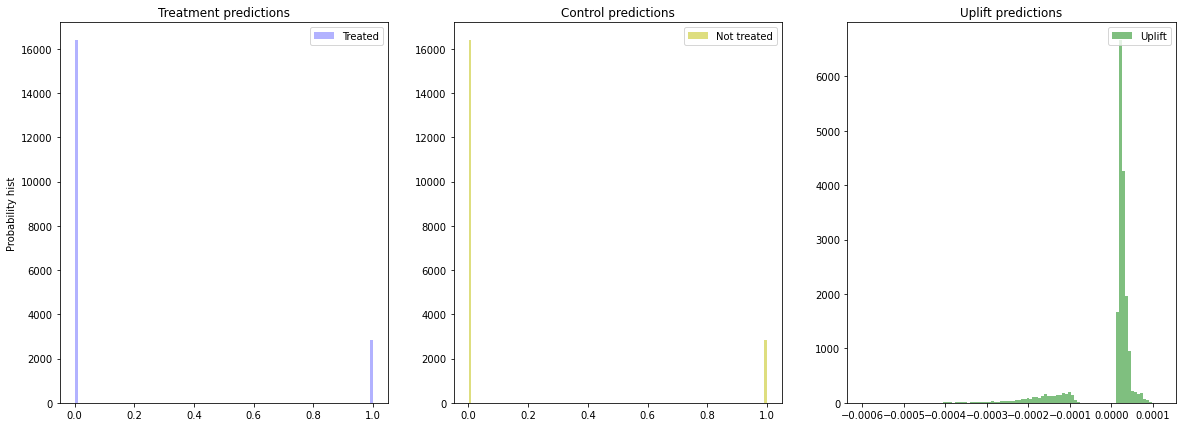

In [154]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})
uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)
print(f'uplift@20%: {sm_score:.4f}')

models_results_2['approach'].append('SoloModel')
models_results_2['uplift@20%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [155]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)

models_results_2['approach'].append('ClassTransformation')
models_results_2['uplift@20%'].append(ct_score)

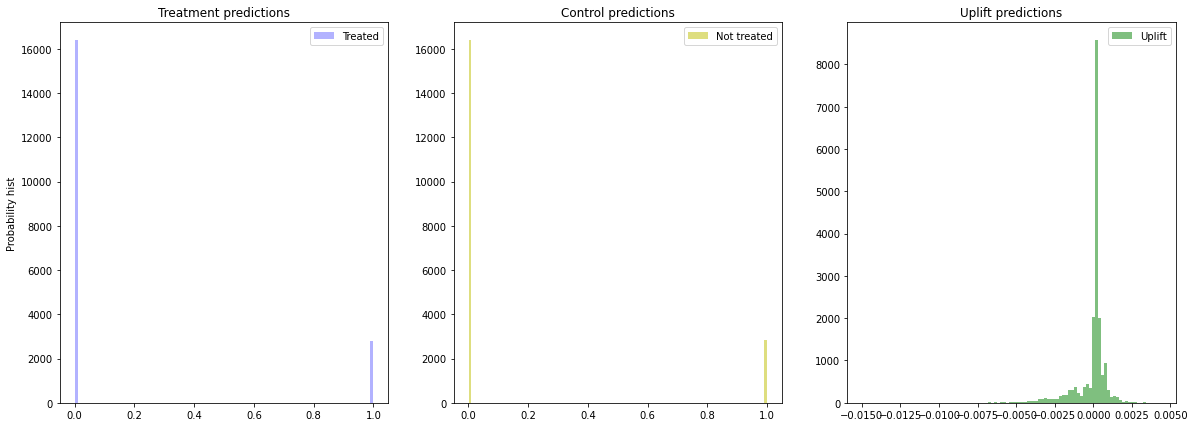

In [156]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)

models_results_2['approach'].append('TwoModels')
models_results_2['uplift@20%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [157]:
pd.DataFrame(data=models_results_1).sort_values('uplift@10%', ascending=False)


,approach,uplift@10%
1,ClassTransformation,1.00000
0,SoloModel,0.00000
2,TwoModels,-0.01017


In [158]:
pd.DataFrame(data=models_results_2).sort_values('uplift@20%', ascending=False)

,approach,uplift@20%
1,ClassTransformation,0.526563
0,SoloModel,0.000000
2,TwoModels,-0.014461
